In [ ]:
#Step 1: clean out data - 
#Final csv file: plot no, sowing date, harvest date, yield, coordinate point (long, lat), polygon (geojson)

In [ ]:
#All code that generates new data --->

In [1]:
#load plot, block, sowing date, harvest date, lat/long [input csv must have these columns]
import pandas as pd

df  = pd.read_csv('./Data/ORI - Consolidate data - AEA 2022-2024 AgriG8.csv')
out = df[['Plot', 'Block', 'Sowing_Date','Harvest_Date', 'Latitude', 'Longitude']]
out.insert(4, 'Yield/HA', None)

for index, row in df.iterrows():
    #print(df.at[index, 'Measured_fresh_yield_T_ha'])
    if pd.isnull(df.at[index, 'Measured_fresh_yield_T_ha']):
        out.at[index, 'Yield'] = df.at[index, 'Declared_Fresh_Yield_T_ha']
    else:
        out.at[index, 'Yield'] = df.at[index, 'Measured_fresh_yield_T_ha']
    
out = out.sort_values(by=['Plot', 'Sowing_Date'], ascending = [True, True])

/tmp/ipykernel_21481/391259599.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out.at[index, 'Yield'] = df.at[index, 'Measured_fresh_yield_T_ha']


In [ ]:
#create all coordinates [input must have list of vertice coordinates and matching PlotID with output above]
import pandas as pd
from shapely.geometry import Point, Polygon
from pyproj import Transformer
from shapely import wkt
# 1) Load the polygons CSV and build the mapping dict

#parsing over farms with the same plotID
poly_df = pd.read_csv('./Data/Merge_Paddyplots_ABCDE.csv')
out['polygon_wkt'] = None
indexPoly = 0 #two pointers one in output data one in polygon coords file
plot = poly_df.at[0, 'PlotID'] #current plotID we are looking at
transformer = Transformer.from_crs("EPSG:32648", "EPSG:4326", always_xy=True)

pts = []
my_list = []
while indexPoly < len(poly_df):
    if poly_df.at[indexPoly, 'PlotID'] == plot:
        x = poly_df.at[indexPoly, 'X']
        y = poly_df.at[indexPoly, 'Y']
        #print(transformer.transform(x, y))
        pts.append((transformer.transform(x, y)))
    else:
        new_poly = Polygon(pts)
        my_list.append(new_poly.wkt)
        plot = poly_df.at[indexPoly, 'PlotID']
        pts = []
    indexPoly += 1
    
#print(my_dict)
for index, row in out.iterrows():
    long = out.at[index, 'Longitude']
    lat = out.at[index, 'Latitude']
    point = Point(long, lat)
    for poly_wkt in my_list:
        poly = wkt.loads(poly_wkt)
        if poly.contains(point):
            print(point)
            out.at[index, 'polygon_wkt'] = poly
out.to_csv('plots_index.csv', index=False)

/tmp/ipykernel_21481/2858934321.py:9: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  poly_df = pd.read_csv('./Data/Merge_Paddyplots_ABCDE.csv')


POINT (103.26437 12.97561)
POINT (103.26437 12.97561)
POINT (103.26358 12.97667)
POINT (103.26358 12.97667)
POINT (103.26825 12.97601)
POINT (103.26825 12.97601)
POINT (103.26814 12.97607)
POINT (103.26814 12.97607)
POINT (103.28479 12.9222)
POINT (103.28482 12.92203)
POINT (103.28479 12.9222)
POINT (103.28482 12.92203)
POINT (103.28479 12.9222)
POINT (103.26599 12.95252)
POINT (103.26599 12.95252)
POINT (103.29472 12.92206)
POINT (103.29472 12.92206)
POINT (103.29472 12.92206)
POINT (103.28208 12.91595)
POINT (103.28208 12.91595)
POINT (103.28208 12.91595)
POINT (103.28208 12.91595)
POINT (103.2821 12.91535)
POINT (103.2821 12.91535)
POINT (103.2821 12.91535)
POINT (103.2811 12.90708)
POINT (103.2811 12.90708)
POINT (103.2811 12.90708)
POINT (103.27286 12.9784)
POINT (103.27272 12.97886)
POINT (103.27286 12.9784)
POINT (103.27272 12.97886)
POINT (103.27286 12.9784)
POINT (103.27286 12.9784)
POINT (103.28426 12.91719)
POINT (103.2843102 12.91723)
POINT (103.28426 12.91719)
POINT (103.2

In [3]:
#filter values - remove plots with missing or invalid sowing/harvest date pairs
import pandas as pd
out  = pd.read_csv('plots_index.csv')
my_dict = {}
for index, row in out.iterrows():
    if not(row["Harvest_Date"] == "" or pd.isna(row.get("Harvest_Date"))):
        start_date = row["Sowing_Date"]
        end_date = row["Harvest_Date"]
        my_dict[row["Sowing_Date"]] = row["Harvest_Date"]
        #print(start_date, end_date)
for index, row in out.iterrows():
    start_date = row["Sowing_Date"]
    end_date = row["Harvest_Date"]
    if row["Harvest_Date"] == "" or pd.isna(row.get("Harvest_Date")):
        if not my_dict.get(start_date) == None:
            out.at[index, "Harvest_Date"] = my_dict[start_date]
            end_date = my_dict[start_date]
        else:
            out.drop(index, inplace=True)
    start_date = pd.to_datetime(start_date, dayfirst=True)
    end_date = pd.to_datetime(end_date, dayfirst=True)
    if end_date - start_date > pd.Timedelta(days=150):
        out.drop(index, inplace=True)
    if end_date - start_date < pd.Timedelta(days=70):
        out.drop(index, inplace = True)
#print(out)
out.to_csv('filtered.csv', index=False)
out = out.reset_index()

In [ ]:
#display data without changing csv --->

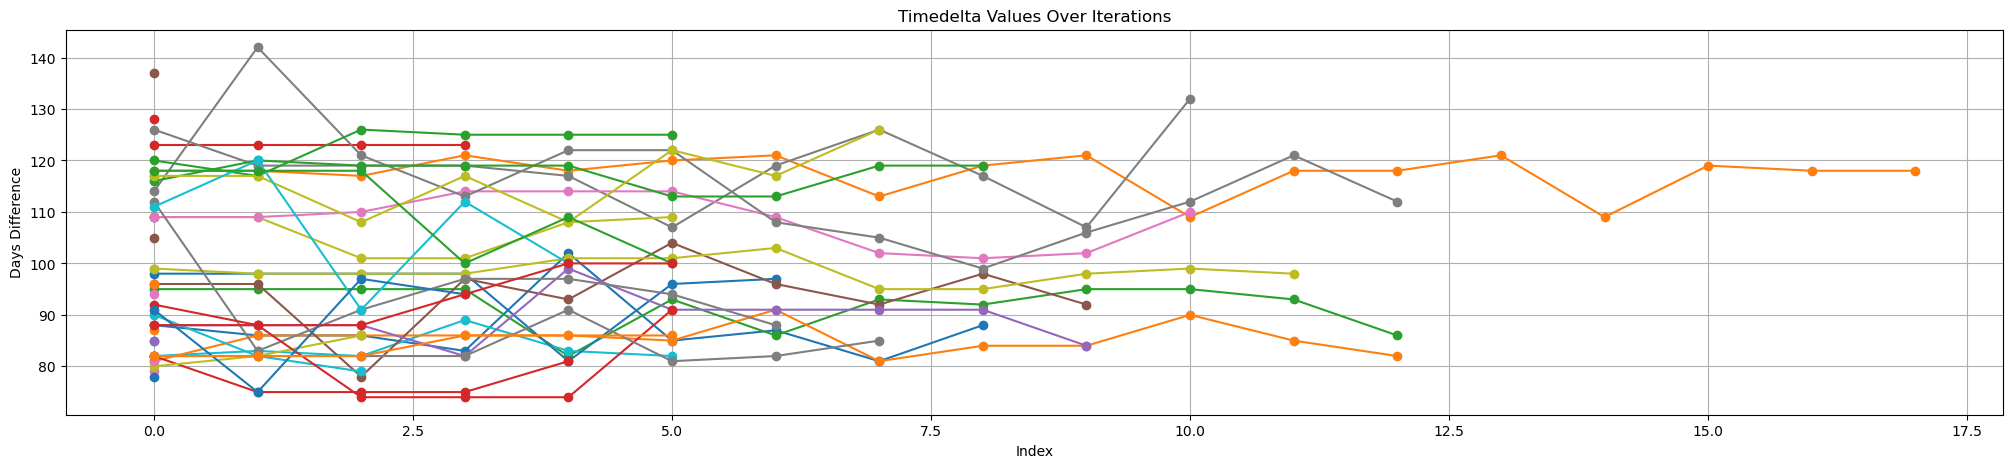

In [5]:
#graph based on block and starting month [input is "out" DataFrame]
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
block_deltas = {}
timedeltas = []
for index, row in out.iterrows():

    start_date = row["Sowing_Date"]
    end_date = row["Harvest_Date"]
    start_date = pd.to_datetime(start_date, dayfirst=True)
    end_date = pd.to_datetime(end_date, dayfirst=True)
    
    block = row["Block"]
    month_key = start_date.strftime("%Y-%m")  # e.g., "2025-01"
    
    if block not in block_deltas:
        block_deltas[block] = {}
    if month_key not in block_deltas[block]:
        block_deltas[block][month_key] = []
    
    
    
    #print(index, start_date, end_date, end_date - start_date)
    #timedeltas.append((end_date-start_date).days)
    block_deltas[block][month_key].append((end_date-start_date).days)



# Plot the timedelta values
plt.figure(figsize=(25, 5))
for block, month_data in block_deltas.items():
    for month, deltas in month_data.items():
        plt.plot(
            range(len(deltas)), 
            deltas, 
            marker='o', 
            label=f'Block {block} - {month}'
        )
        
plt.plot(range(len(timedeltas)), timedeltas, marker='o')
plt.xlabel('Index')
plt.ylabel('Days Difference')
plt.title('Timedelta Values Over Iterations')
plt.grid(True)
plt.show()

In [ ]:
#check if polygons are valid --->

In [15]:
#temporarily convert polygons to geojson code to check if they are all correct polygons [input is list of polygon wkts]
import sys
import json
from shapely.ops import transform as shp_transform
from shapely.geometry import mapping
from shapely import wkt
from pyproj import Transformer

def convert_polygons_to_geojson(polygons, src_epsg="EPSG:32648"):
    """
    Convert a list of WKT polygon strings from a projected CRS to a GeoJSON FeatureCollection in WGS84.

    :param wkt_list: List of WKT polygon strings in the source CRS.
    :param src_epsg: Source CRS (default: "EPSG:32648").
    :return:         Dict representing a GeoJSON FeatureCollection.
    """
    # Transformer from projected CRS → WGS84 lon/lat
    transformer = Transformer.from_crs(src_epsg, "EPSG:4326", always_xy=True)
    project = transformer.transform

    features = []
    for wkt_str in polygons:
        # Parse WKT string to Shapely geometry
        geom = wkt.loads(wkt_str)

        # Reproject geometry
        geom_ll = shp_transform(project, geom)

        # Build GeoJSON Feature
        features.append({
            "type": "Feature",
            "properties": {},
            "geometry": mapping(geom_ll)
        })

    return {"type": "FeatureCollection", "features": features}


# Example: replace this with your actual list of polygons
polygons_projected = my_list

geojson = convert_polygons_to_geojson(polygons_projected)

# pretty-print to stdout
#print(json.dumps(geojson, indent=2))
with open('output.geojson', 'w') as f:
        json.dump(geojson, f, indent=2)

In [ ]:
#Unused/old code --->

In [5]:
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point, Polygon
#check if the long, lat point is within the Polygon wkt
for index, row in out.iterrows():
    long = out.at[index, 'Longitude']
    lat = out.at[index, 'Latitude']
    poly = wkt.loads(out.at[index, 'polygon_wkt'])
    point = Point(long, lat)
    if not poly is None:
        if not poly.contains(point):
            print(out.at[index, 'Plot'], "polygon invalid")
            #print(out.at[index, 'Longitude'], out.at[index, 'Latitude'])
            #print(out.at[index, 'polygon_wkt'])
            x_poly, y_poly = poly.exterior.xy
            # Plot
            plt.figure()
            #plt.plot(x_poly, y_poly, linestyle='-', linewidth=2, label='Polygon Boundary')
            for x, y in poly.exterior.coords:
                plt.scatter(x, y, color='blue', marker='o', label='Inside Points')
                print(x, y)
            plt.scatter(long, lat, color='green', marker='o', label='Inside Points')
            plt.title('Point-in-Polygon Visualization')
            plt.show()

KeyError: 'polygon_wkt'

In [119]:
import geopandas as gpd

# ------ Shapefile ------

# point to the .shp (GeoPandas will load its .dbf, .shx, .prj, .cpg automatically)
shp_path = "./SHP All blocks merged Kanghot/Merge_Paddyplots_ABCDE.shp"
gdf_shp = gpd.read_file(shp_path)
#print(gdf_shp.crs)      # coordinate system from .prj/.qpj
#print(gdf_shp.head())

gpkg_path = "./SHP All blocks merged Kanghot/Merge_Paddyplots_ABCDE.gpkg"

# list layers
#print(gpd.io.file.fiona.listlayers(gpkg_path))

# read one layer by name or index
gdf_gpkg = gpd.read_file(gpkg_path, layer="layer_name")
# or, by index:
# gdf_gpkg = gpd.read_file(gpkg_path, layer=0)

print(gdf_gpkg.crs)
print(gdf_gpkg.head())

DataLayerError: Layer 'layer_name' could not be opened

In [9]:
#retrieve bad data
import pandas as pd
df  = pd.read_csv('./Data/ORI - Consolidate data - AEA 2022-2024 AgriG8.csv')
df = df[['ID', 'Sowing_Date','Harvest_Date']]
out = pd.DataFrame()
for index, row in df.iterrows():
    start_date = row["Sowing_Date"]
    end_date = row["Harvest_Date"]
    if row["Harvest_Date"] == "" or pd.isna(row.get("Harvest_Date")):
        out = pd.concat([out, df.iloc[[index]]], ignore_index=True)
    start_date = pd.to_datetime(start_date, dayfirst=True)
    end_date = pd.to_datetime(end_date, dayfirst=True)
    if end_date - start_date > pd.Timedelta(days=150):
        out = pd.concat([out, df.iloc[[index]]], ignore_index=True)
    if end_date - start_date < pd.Timedelta(days=70):
        out = pd.concat([out, df.iloc[[index]]], ignore_index=True)
out.to_csv('invalid.csv', index=False)

In [ ]:
#Old Polygon Coordinates.csv  geojson to csv version
"""
import pandas as pd
from shapely.geometry import Polygon
# 1) Load the polygons CSV and build the mapping dict

poly_df = pd.read_csv('Polygon Coordinates.csv')
out['polygon_wkt'] = None
indexPoly = 0 #two pointers one in output data one in polygon coords file

long = poly_df.at[0, 'Longitude']
lat = poly_df.at[0, 'Latitude']
pts = []
my_dict = {}
while indexPoly < len(poly_df):
    if poly_df.at[indexPoly, 'Longitude'] == long and poly_df.at[indexPoly, 'Latitude'] == lat:
        pts.append((poly_df.at[indexPoly, 'X'], poly_df.at[indexPoly, 'Y']))
    else:
        new_poly = Polygon(pts)
        my_dict[(long, lat)] = new_poly.wkt
        long = poly_df.at[indexPoly, 'Longitude']
        lat = poly_df.at[indexPoly, 'Latitude']
        pts = []
    indexPoly += 1
    
#print(my_dict)
for index, row in out.iterrows():
    long = out.at[index, 'Longitude']
    lat = out.at[index, 'Latitude']
    if (long, lat) in my_dict:
        out.at[index, 'polygon_wkt'] = my_dict[(long, lat)]
    else:
        print(out.at[index, 'Plot'], "Does not exist.")
        out.at[index, 'polygon_wkt'] = None

    

out.to_csv('plots_index.csv', index=False)
"""

In [ ]:
#old output_with_WKT.csv version

"""
import pandas as pd
from shapely.geometry import Polygon
poly_df  = pd.read_csv('output_with_WKT.csv')            # has columns AEA, polygon_wkt\
poly_df = poly_df.drop_duplicates(subset = 'Plot No')
aea_to_poly = dict(zip(poly_df[ 'Plot No'], poly_df['polygon_wkt']))
"""
"""
for index, row in df.iterrows():
    long = out.at[index, 'Longitude']
    lat = out.at[index, 'Latitude']
    pts = []
    while indexPoly < len(poly_df):
        if poly_df.at[indexPoly, 'Longitude'] == long and poly_df.at[indexPoly, 'Latitude'] == lat:
            pts.append((poly_df.at[indexPoly, 'X'], poly_df.at[indexPoly, 'Y']))
        else:
            break
        indexPoly += 1
    #print(pts)

    if not pts is None:
        new_poly = Polygon(pts)
        out.at[index, 'polygon_wkt'] = new_poly.wkt
for index, row in out.iterrows():
    plot = row['Plot']
    if plot in aea_to_poly:
        out.at[index, 'polygon_wkt'] = aea_to_poly[plot]
    else:
        print(plot, "Does not exist.")
        out.at[index, 'polygon_wkt'] = None
"""